In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


98 6272 64.0 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,1.00,...,0.978689,0.985999,0.972647,0.982941,0.983447,0.985028,0.923947,0.920410,0.977171,0.988160
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,1.00,...,0.984116,0.984782,0.969335,0.980352,0.979375,0.985628,0.910105,0.933163,0.949498,0.964510
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,0.00,...,0.978814,0.982546,0.000000,0.000000,0.000000,0.000000,0.854408,0.866689,0.928334,0.945839
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,0.00,...,0.988970,0.988449,0.000000,0.000000,0.000000,0.000000,0.923947,0.920410,0.977171,0.988160
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0.25,...,0.984601,0.983148,0.000000,0.000000,0.000000,0.000000,0.978064,0.979764,0.973707,0.988379


In [47]:
len([c for c in fitness_df.columns if 'arg_types' in c])

344

In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df

model_path = '../models/cv_fitness_model_2023_03_07_1.pkl.gz'
data_df = fitness_df

with gzip.open(model_path, 'rb') as f:
    cv_energy_model, feature_columns = utils.load_model_and_feature_columns('2023_03_07_1')



## Histogram the weights to get a sense of what we're dealing with

Weights mean: -1.1652, std: 6.3718, bias: 39.3752


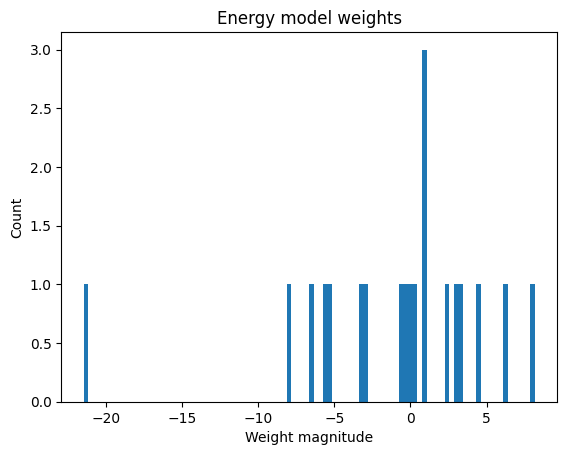

In [6]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=100)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [7]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (2, 10.00%) of the weights have magnitude < 0.1890
Approximately 25.0% (5, 25.00%) of the weights have magnitude < 0.8162
Approximately 50.0% (10, 50.00%) of the weights have magnitude < 2.8825
Approximately 75.0% (15, 75.00%) of the weights have magnitude < 5.5245
Approximately 90.0% (18, 90.00%) of the weights have magnitude < 8.0204
Approximately 95.0% (19, 95.00%) of the weights have magnitude < 8.1707


## Print the top K features most and least predictive of real games

In [8]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_full_n_7_score (-21.4751)
2. ast_ngram_terminal_n_5_score (-8.0191)
3. ast_ngram_scoring_n_5_score (-6.3729)
4. ast_ngram_setup_n_5_score (-5.5206)
5. ast_ngram_constraints_n_7_score (-5.3669)
6. all_variables_used (-3.3365)
7. all_preferences_used (-2.8762)
8. no_two_number_operations (-0.6798)
9. section_without_pref_or_total_count_terminal (-0.1876)
10. no_adjacent_same_modal (0.0336)
11. nested_logicals_found (0.2759)
12. section_without_pref_or_total_count_scoring (0.8160)
13. tautological_expression_found (0.9288)
14. identical_logical_children_found (0.9346)
15. all_variables_defined (2.3983)
16. adjacent_once_found (2.8784)
17. redundant_expression_found (3.3888)
18. repeated_variables_found (4.5780)
19. section_exists_setup (6.1286)
20. section_exists_terminal (8.1695)
### Features with largest positive weights (most predictive of fake games):
1. section_exists_terminal (8.1695)
2. section_exists_setup (6.1286)
3. repeated_variables_found (4.5780)
4. redundant_expression_found (3.3888)
5. adjacent_once_found (2.8784)
6. all_variables_defined (2.3983)
7. identical_logical_children_found (0.9346)
8. tautological_expression_found (0.9288)
9. section_without_pref_or_total_count_scoring (0.8160)
10. nested_logicals_found (0.2759)
11. no_adjacent_same_modal (0.0336)
12. section_without_pref_or_total_count_terminal (-0.1876)
13. no_two_number_operations (-0.6798)
14. all_preferences_used (-2.8762)
15. all_variables_used (-3.3365)
16. ast_ngram_constraints_n_7_score (-5.3669)
17. ast_ngram_setup_n_5_score (-5.5206)
18. ast_ngram_scoring_n_5_score (-6.3729)
19. ast_ngram_terminal_n_5_score (-8.0191)
20. ast_ngram_full_n_7_score (-21.4751)

In [ ]:
weights[feature_columns.index('in_motion_arg_types_any_object_setup')]

In [ ]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'found' in c]

In [ ]:
data_df.groupby('real').repeated_variables_found.describe()

In [ ]:
data_df.groupby('real').no_identical_logical_children.describe()

In [ ]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'exists' in c]

In [ ]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if c.startswith('ast_ngram') and c.endswith('score')]

## Plot a histogram of the values for each of the and bottom K features

In [9]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {feature_columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

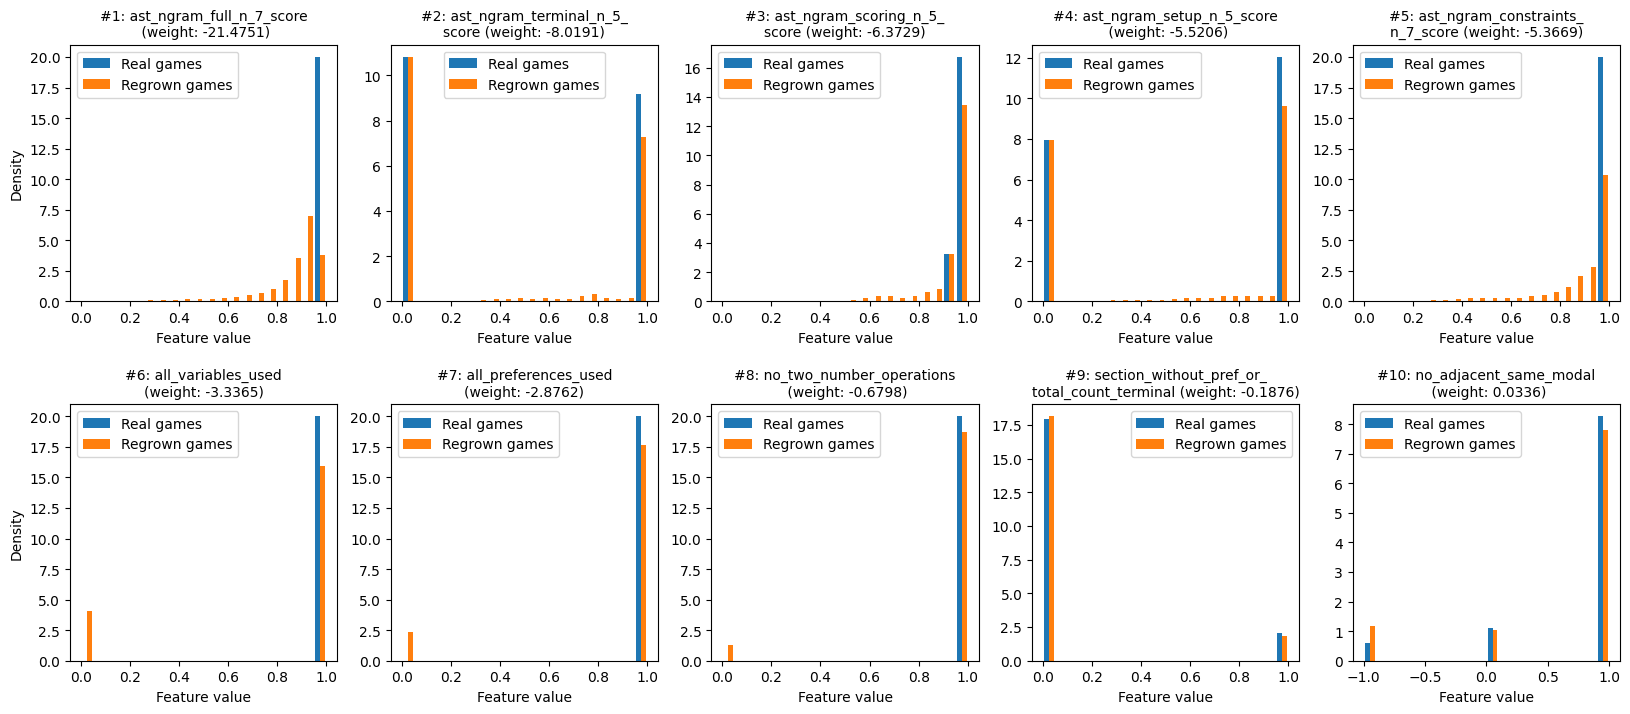

In [10]:
k = 10
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

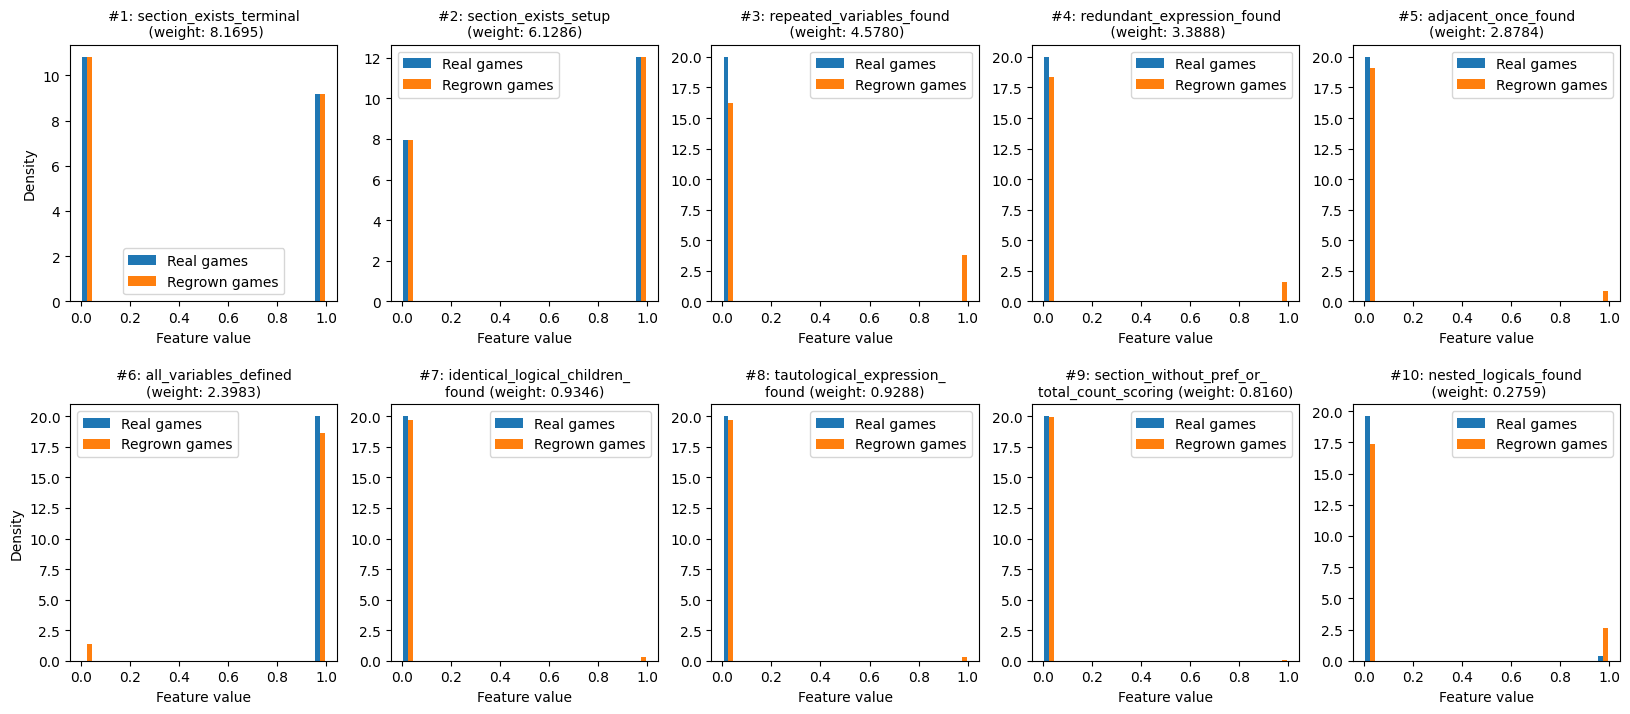

In [11]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [12]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [13]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}')

Real game scores: 2.9289 ± 0.4843


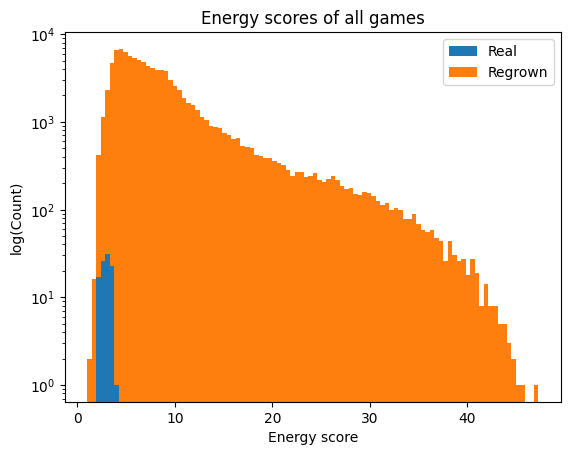

In [14]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [15]:
negatives_scores = full_tensor_scores[:, 1:]

In [16]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [17]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-1.6783, -1.3500, -1.2657, -1.2191, -1.2057, -1.1988, -1.1961, -1.1961,
        -1.1934, -1.1373]),
indices=tensor([25844, 67030, 91951, 52478, 52629, 40909, 19388, 18861, 22805, 18814]))

In [ ]:
N_NEGATIVES = 10
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False)
    
    display(Markdown('---'))

## If we never need to load a featurizer for anything


In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_02_14.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

## Analyzing the role of different variables on the difficulty of the negative

In [36]:
NEGATIVE_DIFFICULTY_COLUMNS = [
    'game_name', 'regrowth_index', 
    'original_game_name', 'original_game_index', 
    'node_depth', 'regrowth_depth', 
    'regrowth_section', 'regrowth_sampler', 
    'score_diff'
]

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)


game_name_to_index = {game_name: i for i, game_name in enumerate(data_df.loc[data_df.real == 1, 'game_name'])}


def extract_info_from_game_name(game_name: str):
    i = utils._find_nth(game_name, '-', 2)
    original_game_name, regrowth_info = game_name[:i], game_name[i + 1:]
    regrowth_index, _, node_depth, _, regrowth_depth, _, regrowth_section, _, regrowth_sampler = regrowth_info.split('-')
    regrowth_index = int(regrowth_index)
    node_depth = int(node_depth)
    regrowth_depth = int(regrowth_depth)
    original_game_index = game_name_to_index[original_game_name]
    score_diff = score_diffs[original_game_index, regrowth_index].item()
    return [regrowth_index, original_game_name, original_game_index, node_depth, regrowth_depth, regrowth_section, regrowth_sampler, score_diff]


negative_difficulty_df = data_df.loc[data_df.real == 0, ['game_name']]
negative_difficulty_df = apply_and_concat(negative_difficulty_df, 'game_name', extract_info_from_game_name, NEGATIVE_DIFFICULTY_COLUMNS[1:])




In [45]:
print(negative_difficulty_df.iloc[100]['game_name'])
extract_info_from_game_name(negative_difficulty_df.iloc[100]['game_name'])

6172feb1665491d1efbce164-0-100-nd-0-rd-2-rs-scoring-sk-prior1


[100,
 '6172feb1665491d1efbce164-0',
 0,
 0,
 2,
 'scoring',
 'prior1',
 3.0188636779785156]

In [37]:
negative_difficulty_df.head()

,game_name,regrowth_index,original_game_name,original_game_index,node_depth,regrowth_depth,regrowth_section,regrowth_sampler,score_diff
98,6172feb1665491d1efbce164-0-0-nd-0-rd-11-rs-con...,0,6172feb1665491d1efbce164-0,0,0,11,constraints,prior6,9.039309
99,6172feb1665491d1efbce164-0-1-nd-0-rd-2-rs-cons...,1,6172feb1665491d1efbce164-0,0,0,2,constraints,prior11,6.387781
100,6172feb1665491d1efbce164-0-2-nd-0-rd-6-rs-cons...,2,6172feb1665491d1efbce164-0,0,0,6,constraints,prior11,3.475876
101,6172feb1665491d1efbce164-0-3-nd-0-rd-2-rs-cons...,3,6172feb1665491d1efbce164-0,0,0,2,constraints,prior1,1.457584
102,6172feb1665491d1efbce164-0-4-nd-0-rd-2-rs-scor...,4,6172feb1665491d1efbce164-0,0,0,2,scoring,prior11,4.330618


In [39]:
negative_difficulty_df.groupby('regrowth_sampler').score_diff.describe()

,count,mean,std,min,25%,50%,75%,max
regrowth_sampler,,,,,,,,
prior1,33030.0,5.985726,6.074056,-1.349979,1.861278,4.254875,7.478703,42.433590
prior11,33940.0,6.098116,6.173939,-1.137253,2.005898,4.376417,7.523677,45.030968
prior6,33382.0,6.122001,6.221485,-1.678265,1.961056,4.335629,7.587590,42.038681


In [40]:
negative_difficulty_df.groupby('regrowth_section').score_diff.describe()

,count,mean,std,min,25%,50%,75%,max
regrowth_section,,,,,,,,
constraints,53043.0,7.638048,7.295598,-1.678265,2.194969,5.422441,10.344011,45.030968
scoring,24057.0,2.958957,2.188367,-0.609249,1.189449,2.876179,4.334881,15.970560
setup,12763.0,6.436304,5.571961,-0.866314,2.616951,5.256193,8.000361,37.419838
terminal,10489.0,4.821058,2.908458,-0.157249,2.692039,4.615158,6.491550,18.601038


In [42]:
negative_difficulty_df.groupby('regrowth_depth').score_diff.describe()

,count,mean,std,min,25%,50%,75%,max
regrowth_depth,,,,,,,,
1,14759.0,3.046167,2.586108,-0.273521,1.074436,2.535069,4.504270,17.768625
2,13630.0,3.979190,3.146916,-1.678265,1.603362,3.492100,5.396902,22.890392
3,15288.0,3.906447,2.751929,-1.196091,1.734081,3.484804,5.482957,25.541920
4,12653.0,5.598205,4.743680,-1.198780,2.039154,4.612011,7.494202,35.923592
5,6985.0,5.354736,4.402650,-0.694370,2.234558,4.500008,6.990835,34.562904
6,6777.0,6.079106,5.661848,-0.272099,1.983185,4.675137,7.956867,39.377438
7,4164.0,6.678901,5.700595,-0.117596,2.846595,5.493020,8.321756,41.783741
8,5391.0,7.957393,6.812070,-0.224003,3.033398,6.092470,10.622300,39.040939
9,4674.0,6.700561,6.843677,-0.133537,2.082978,4.602251,8.442596,42.834389
